100%|██████████| 23/23 [00:24<00:00,  1.08s/it]


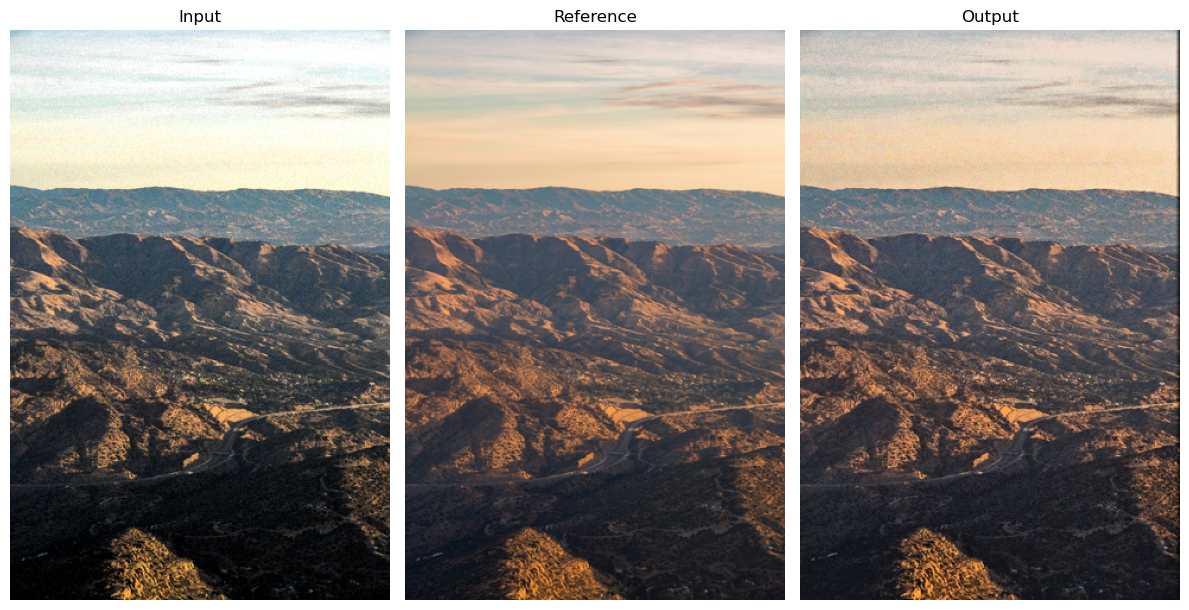

In [1]:
import numpy as np
from tqdm import tqdm
from editor.visualisation import display_images, plot_histograms_in_3d
from editor.utils import compute_histogram, kldiv
from editor.histogram_transfer import pdf_transfer_3d
import plotly.graph_objects as go
from PIL import Image
from editor.training import HistogramDataset
from config import DATA


EPSILON = 1e-6
BINS = 32
dataset = HistogramDataset(DATA, bin_count=BINS)

og = np.array(dataset.get_original_image(1437))
edit = np.array(dataset.get_edited_image(1437, edit_idx=96646))

ys = []
[h, w, c] = og.shape

reference_flattened = og.reshape(-1, c).transpose()
for i in tqdm(range(2, 25)):
    img_arr_out = pdf_transfer_3d(
        source=edit,
        target_flattened=reference_flattened,
        relaxation=1,
        bin_count=1000,
        iterations=i,
        smoothness=1,
    )
    ys.append(
        kldiv(
            compute_histogram(img_arr_out, bins=BINS),
            compute_histogram(og, bins=BINS),
        )
    )


plot_histograms_in_3d(
    {
        "Input": compute_histogram(edit, bins=BINS),
        "Reference": compute_histogram(og, bins=BINS),
        "Output": compute_histogram(img_arr_out, bins=BINS),
    }
)
display_images(
    {
        "Input": Image.fromarray(edit),
        "Reference": Image.fromarray(og),
        "Output": Image.fromarray(img_arr_out),
    }
)

go.Figure(go.Scatter(x=list(range(len(ys))), y=ys, mode="lines+markers", name="Data"))